<img src = "https://api.time.com/wp-content/uploads/2018/03/fearless-girl-statue-international-womens-day-2018.jpg" style = "margin: -50px 0 -75px 0">

# Stock Tweets Sentiment Analysis

## Predicting Stock Market Price Movement Based on Sentiment Analysis

In [1]:
# import basic packages
import numpy as np
import pandas as pd

# import visualisaation packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8] # preset chart size

# import NLP and text manipulation packages
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer

# machine learning tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# download stopwords and other data
nltk.download('stopwords')
stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Defor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Defor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Defor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Exploratory Data Analysis - Stock Tweets

In [3]:
df1 = pd.read_csv("stock_sentiment.csv")
df1.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [4]:
print(f'There are {df1.shape[0]} rows and {df1.shape[1]} columns in stock_sentiment.csv')
print(f'Are there any missing values? {df1.empty}')

There are 5791 rows and 2 columns in stock_sentiment.csv
Are there any missing values? False


1    3685
0    2106
Name: Sentiment, dtype: int64


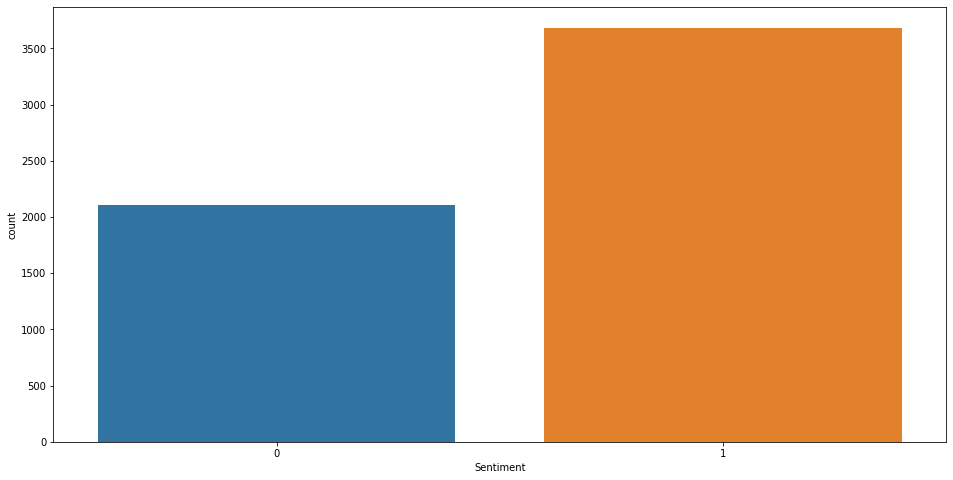

In [5]:
# number of positive and negative sentiment
print(df1["Sentiment"].value_counts())
sns.countplot(x = "Sentiment", data = df1)

Text(0.5, 1.0, 'Top 20 words before removing stop words')

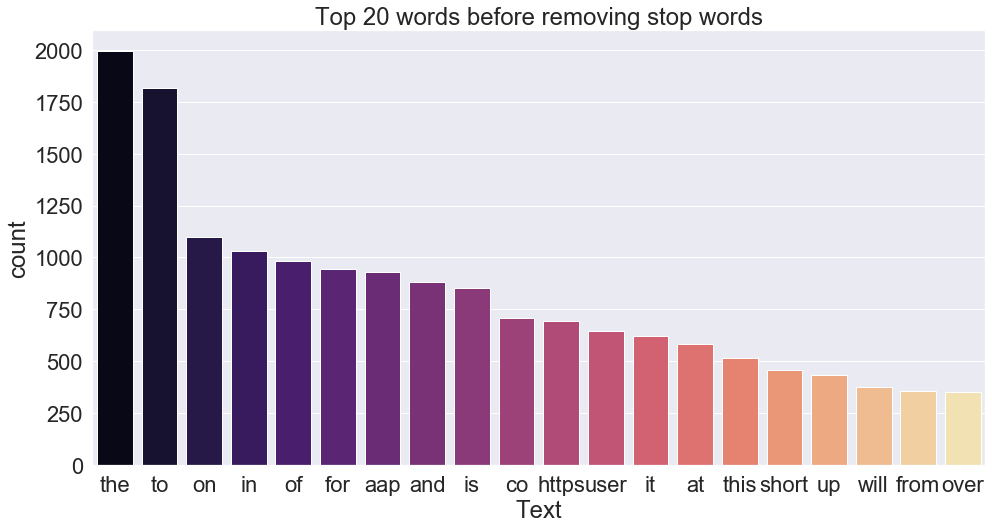

In [6]:
# consolidate text and get top words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df1['Text'], 20)

# create dataframe of top words
df_count_top_words = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale= 2)
sns.barplot(x = "Text", y = "count", data = df_count_top_words, palette="magma").set_title("Top 20 words before removing stop words")


In [7]:
df1["text_len"] = df1.Text.apply(len)
df1.head()

,Text,Sentiment,text_len
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,95
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,95
2,user I'd be afraid to short AMZN - they are lo...,1,114
3,MNTA Over 12.00,1,17
4,OI Over 21.37,1,16


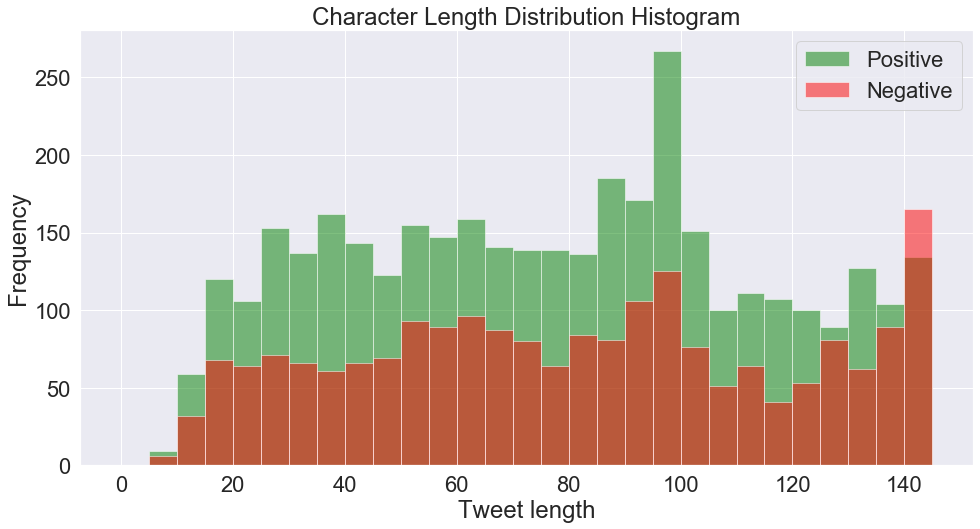

In [8]:
# plot positive sentiment distribution
df1[df1.Sentiment == 1].text_len.plot(kind='hist', color='green', label = "Positive", 
                                      bins = np.arange(0,150,5), alpha = 0.5,
                                      title = "Character Length Distribution Histogram")

# plot negative sentiment distribution
df1[df1.Sentiment == 0].text_len.plot(kind='hist', color='red', label = "Negative", 
                                      bins = np.arange(0,150,5), alpha = 0.5)

# plot elements
plt.xlabel("Tweet length")
plt.legend(loc="upper right")

In [9]:
# snippet of the longest tweet
longest_tweet = df1[df1.text_len == max(df1.text_len)]
print(longest_tweet.index)
print(longest_tweet.Text.iloc[0])

Int64Index([5193], dtype='int64')
RT @Spencerjakab: Please ignore the â€œI saw the coronavirus coming, hereâ€™s whatâ€™s nextâ€ stuff and read my latest for â¦@WSJheardâ© instead httâ€¦


# Exploratory Data Analysis - User Profile

In [10]:
df2 = pd.read_csv("user_profile.csv")
df2.set_index("User ID", inplace=True)
df2.head()

,Gender,Age,EstimatedSalary,Futures,Sentiment,Returns
User ID,,,,,,
15624510,Male,19,19000,-1.456902,1,1.323369
15810944,Male,35,20000,-1.199012,1,0.129326
15668575,Female,26,43000,-1.221235,1,-0.420350
15603246,Female,27,57000,-0.721154,1,-0.522536
15804002,Male,19,76000,-0.608924,1,-1.030991


In [11]:
print(f'There are {df2.shape[0]} rows and {df2.shape[1]} columns in user_profile.csv')
print(f'Are there any missing values? {df2.empty}')

There are 5791 rows and 6 columns in user_profile.csv
Are there any missing values? False


In [12]:
df2.describe()

,Age,EstimatedSalary,Futures,Sentiment,Returns
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000
mean,36.648075,106125.712312,-0.004746,0.636332,0.200226
std,10.593353,52449.729994,1.500148,0.481096,2.002614
min,18.000000,15000.000000,-5.068559,0.000000,-7.095149
25%,30.000000,60000.000000,-1.021317,0.000000,-1.112098
50%,36.000000,104000.000000,0.008559,1.000000,0.201252
75%,42.000000,150000.000000,1.021599,1.000000,1.547922
max,77.000000,200000.000000,7.278598,1.000000,7.283090


Text(0.5, 1.0, 'How old are the Twitter users?')

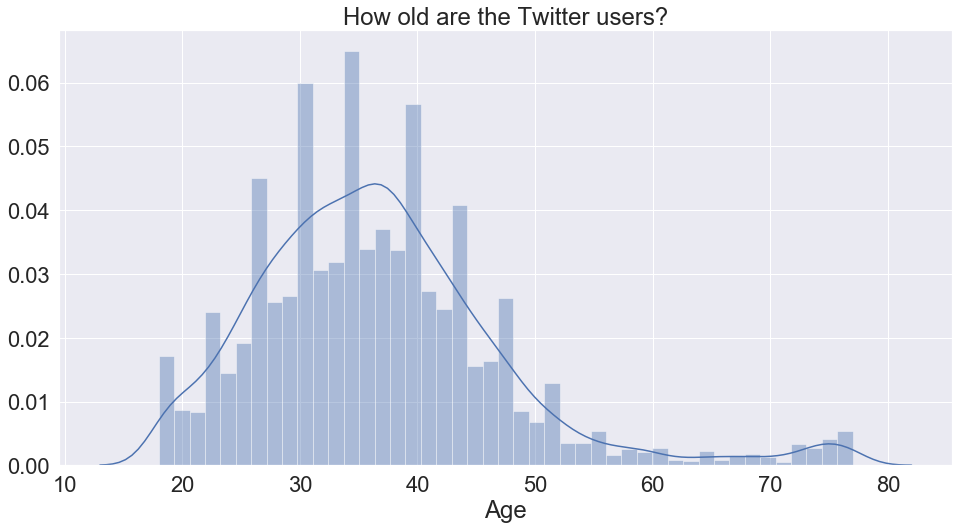

In [13]:
sns.distplot(a=df2.Age).set_title("How old are the Twitter users?")

Text(0.5, 1.0, 'S&P Futures and Return Correlation Plot')

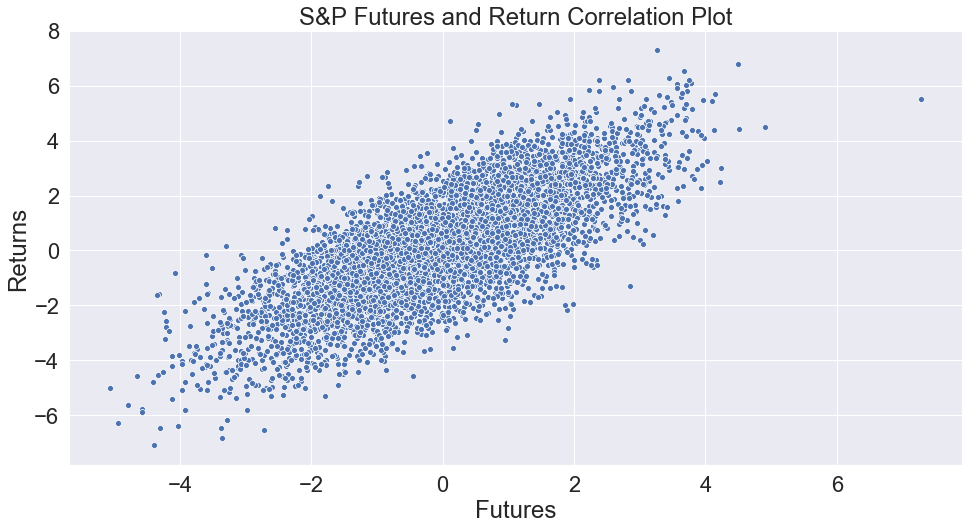

In [14]:
sns.scatterplot(x = "Futures", 
                y = "Returns", 
                data = df2).set_title("S&P Futures and Return Correlation Plot")

[Text(0.5, 1.0, 'Distribution of Age by Sentiment and Gender')]

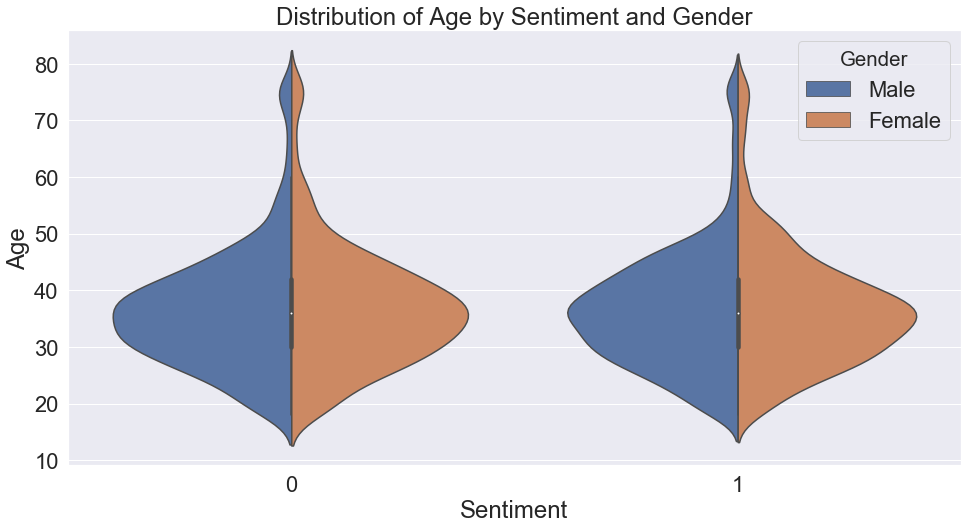

In [15]:
ax =sns.violinplot(x="Sentiment", y="Age", hue="Gender", data=df2, split = True)
ax.set(title = "Distribution of Age by Sentiment and Gender")

Text(0.5, 1.0, 'Salary Distribution of Twitter Users')

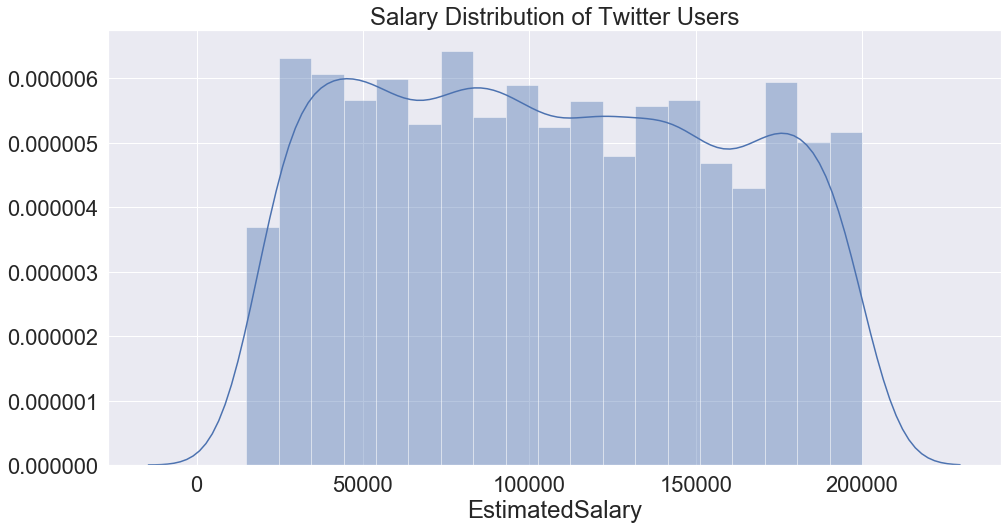

In [16]:
sns.distplot(df2.EstimatedSalary).set_title("Salary Distribution of Twitter Users")

# Data Cleaning

In [17]:
# prepare text cleaning tools
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words.extend(['rt','retweet','re','edu','use','will','aap','co','day','user','stock','today','week','year', 'https'])

In [18]:
# example tweet for cleaning
example = df1['Text'][5193]

# print one by one to see what is going on
print("1)", example)

text = re.sub('@[^\s]+', "", example) # remove @ mentions
text = re.sub('http\S+', "", text)    # remove urls
text = re.sub('[^a-zA-Z]'," ", text)  # clearing special characters and numbers
print("2)",text)

text = text.lower()                            # lower case
print("3)",text)

text = word_tokenize(text,language='english')  # tokenisation
print("4)",text)

# remove stop words and lemmatize
text = [lemma.lemmatize(word) for word in text if(word) not in stop_words] 
print("5)",text)

text = " ".join(text)                          # join
print("6)",text)

1) RT @Spencerjakab: Please ignore the â€œI saw the coronavirus coming, hereâ€™s whatâ€™s nextâ€ stuff and read my latest for â¦@WSJheardâ© instead httâ€¦
2) RT  Please ignore the    I saw the coronavirus coming  here   s what   s next    stuff and read my latest for     instead htt   
3) rt  please ignore the    i saw the coronavirus coming  here   s what   s next    stuff and read my latest for     instead htt   
4) ['rt', 'please', 'ignore', 'the', 'i', 'saw', 'the', 'coronavirus', 'coming', 'here', 's', 'what', 's', 'next', 'stuff', 'and', 'read', 'my', 'latest', 'for', 'instead', 'htt']
5) ['please', 'ignore', 'saw', 'coronavirus', 'coming', 'next', 'stuff', 'read', 'latest', 'instead', 'htt']
6) please ignore saw coronavirus coming next stuff read latest instead htt


In [19]:
# example tweet for cleaning
example = df1['Text'][934]

# print one by one to see what is going on
print("1)", example)

text = re.sub('@[^\s]+', "", example) # remove @ mentions
text = re.sub('http\S+', "", text)    # remove urls
text = re.sub('[^a-zA-Z]'," ", text)  # clearing special characters and numbers
print("2)",text)

text = text.lower()                            # lower case
print("3)",text)

text = word_tokenize(text,language='english')  # tokenisation
print("4)",text)

# remove stop words and lemmatize
text = [lemma.lemmatize(word) for word in text if(word) not in stop_words] 
print("5)",text)

text = " ".join(text)                          # join 
print("6)",text)

1) Added to holdings in AAP BID FB in AH. Also holding DDD. Down to 25% cash. 
2) Added to holdings in AAP BID FB in AH  Also holding DDD  Down to     cash  
3) added to holdings in aap bid fb in ah  also holding ddd  down to     cash  
4) ['added', 'to', 'holdings', 'in', 'aap', 'bid', 'fb', 'in', 'ah', 'also', 'holding', 'ddd', 'down', 'to', 'cash']
5) ['added', 'holding', 'bid', 'fb', 'ah', 'also', 'holding', 'ddd', 'cash']
6) added holding bid fb ah also holding ddd cash


In [20]:
# preprocess all tweets in dataframe
textList = list()
for i in range(len(df1)):
    text = re.sub('@[^\s]+', "", df1['Text'][i])
    text = re.sub('http\S+', "", text)
    text = re.sub('[^a-zA-Z]'," ", text)
    text = re.sub('[^a-zA-Z]'," ", text)
    text = text.lower()
    text = word_tokenize(text,language='english')
    text = [lemma.lemmatize(word) for word in text if(word) not in stop_words]
    text = " ".join(text)
    textList.append(text)

In [21]:
textList

['kicker watchlist xide tit soq pnk cpw bpz aj trade method method see prev post',
 'movie return fea geed indicator trade awesome',
 'afraid short amzn looking like near monopoly ebooks infrastructure service',
 'mnta',
 'oi',
 'pgnx',
 'current downtrend break otherwise short term correction med term downtrend',
 'monday relative weakness nyx win tie tap ice int bmc aon c chk biib',
 'goog ower trend line channel test volume support',
 'watch tomorrow ong entry',
 'assuming fcx open tomorrow trigger buy still much like setup',
 'really worry everyone expects market rally usually exact opposite happens every time shall see soon bac spx jpm',
 'gamco arry haverty apple extremely cheap great video',
 'maykiljil posted agree msft going higher possibly north',
 'momentum coming back etfc broke resistance solid volume friday ong set',
 'ha hitting mean resume targeting level',
 'gameplan shot liked trend break may c h break oc weekly trend break back july',
 'fcx gapping well ideal entry l

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

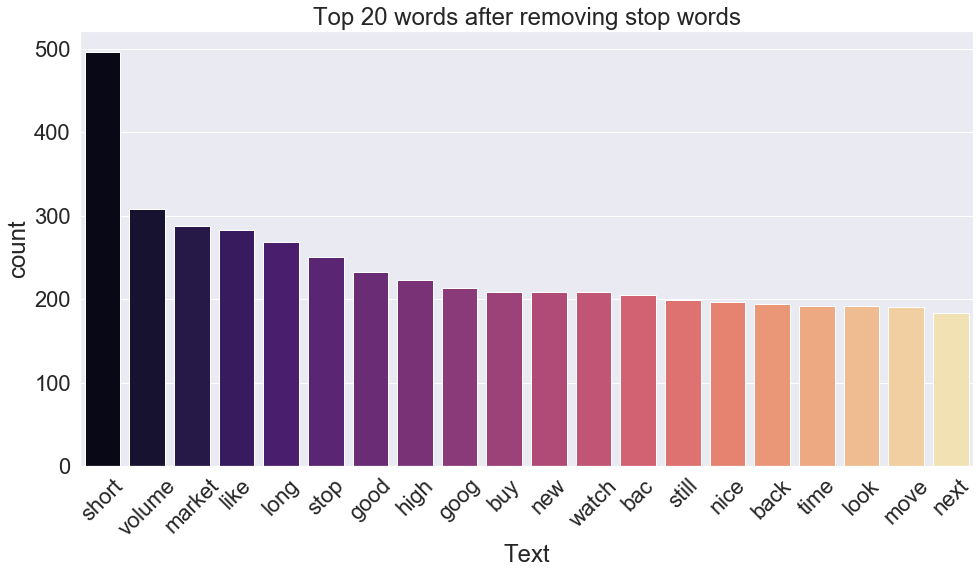

In [22]:
common_words_cleaned = get_top_n_words(textList, n=20)

df_count_top_words_cleaned = pd.DataFrame(common_words_cleaned,
                                          columns = ['Text' , 'count'])

# plot elements
sns.set(font_scale= 2)
sns.barplot(x = "Text", y = "count", 
            data = df_count_top_words_cleaned, 
            palette="magma").set_title("Top 20 words after removing stop words")

plt.xticks(rotation=45)

# Modelling

## Bernoulli Naive Bayes

In [23]:
cv = CountVectorizer()
pca = PCA(n_components=256)

# split the data into test and train 
x = cv.fit_transform(textList).toarray() # Convert to document-term matrix to array format 
x = pca.fit_transform(x)                 # reduce dimensionality

y = df1["Sentiment"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [24]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(x_train,y_train)         # training of data
y_pred = nb.predict(x_test)     # testing of data
accuracy = accuracy_score(y_test,y_pred)
print(f"Bernoulli Naive Bayes Accuracy: {accuracy}")

Bernoulli Naive Bayes Accuracy: 0.6902502157031924


In [25]:
def plotconfusionmatrix (y_test,y_pred, modelname = ""):
    cm = confusion_matrix(y_test,y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(cm, annot=labels, fmt='', cmap='PuRd').set_title(f"{modelname} Confusion Matrix")

Text(0.5, 1, 'Bernoulli Naive Bayes Confusion Matrix')

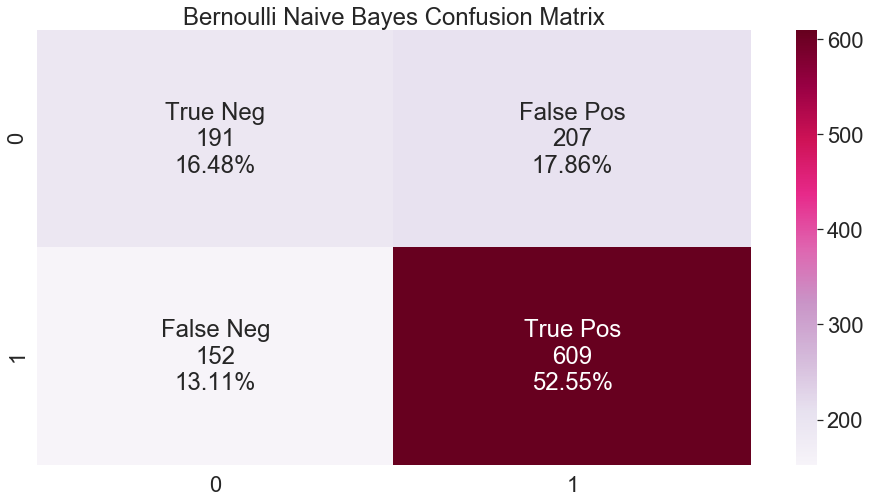

In [26]:
plotconfusionmatrix (y_test,y_pred, modelname = "Bernoulli Naive Bayes")

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.48      0.52       398
           1       0.75      0.80      0.77       761

    accuracy                           0.69      1159
   macro avg       0.65      0.64      0.64      1159
weighted avg       0.68      0.69      0.68      1159



## Support Vector Machine

In [28]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train,y_train)         # training of data
y_pred = svc.predict(x_test)     # testing of data
accuracy = accuracy_score(y_test,y_pred)
print(f"Support Vector Machine Accuracy: {accuracy}")

Support Vector Machine Accuracy: 0.7679033649698016


Text(0.5, 1, 'Support Vector Machine Confusion Matrix')

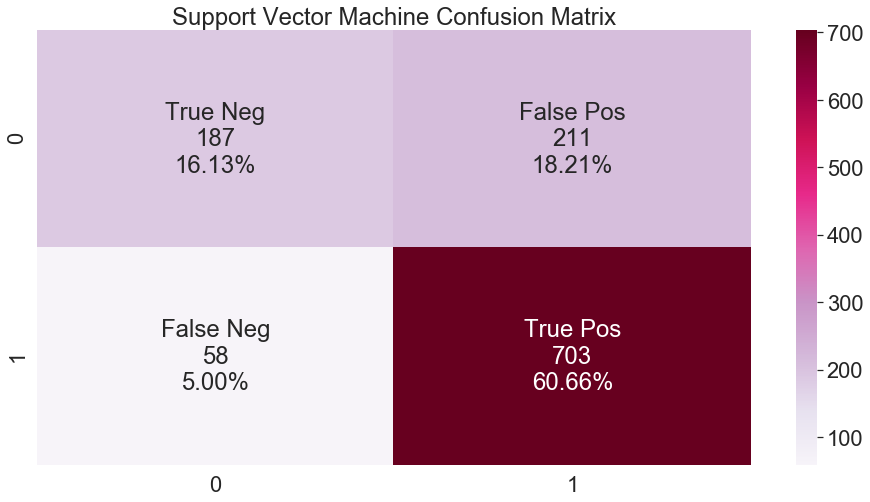

In [29]:
plotconfusionmatrix (y_test,y_pred, modelname = "Support Vector Machine")

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58       398
           1       0.77      0.92      0.84       761

    accuracy                           0.77      1159
   macro avg       0.77      0.70      0.71      1159
weighted avg       0.77      0.77      0.75      1159



In [31]:
check = df1["Sentiment"].values == df2["Sentiment"].values

matches = (check == True).sum()
non_matches = (check == False).sum()

print(f"There are a total of {matches} matches")
print(f"There are a total of {non_matches} non-matches")

There are a total of 5791 matches
There are a total of 0 non-matches


In [32]:
df2

,Gender,Age,EstimatedSalary,Futures,Sentiment,Returns
User ID,,,,,,
15624510,Male,19,19000,-1.456902,1,1.323369
15810944,Male,35,20000,-1.199012,1,0.129326
15668575,Female,26,43000,-1.221235,1,-0.420350
15603246,Female,27,57000,-0.721154,1,-0.522536
15804002,Male,19,76000,-0.608924,1,-1.030991
...,...,...,...,...,...,...
15683480,Female,27,96000,0.436550,0,-0.361504
15612223,Male,43,148000,-2.719183,0,-4.296772
15878424,Female,72,141000,2.002899,1,-0.608770


In [33]:
# one hot encoding for male and female
df2['Gender'].replace({'Female':0, 'Male':1},inplace=True)

# convert returns to binary 
df2['Returns'][df2['Returns'] < 0] = 0
df2['Returns'][df2['Returns'] > 0] = 1
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Gender,Age,EstimatedSalary,Futures,Sentiment,Returns
User ID,,,,,,
15624510,1,19,19000,-1.456902,1,1.0
15810944,1,35,20000,-1.199012,1,1.0
15668575,0,26,43000,-1.221235,1,0.0
15603246,0,27,57000,-0.721154,1,0.0
15804002,1,19,76000,-0.608924,1,0.0


# Decision Tree

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

# split the data into test and train
x = df2.drop(['Returns'], axis=1)
y = df2['Returns']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# hyperparameter tuning
parameters = {'criterion':('gini', 'entropy'), 
              'min_samples_split': range(50, 1000, 50), 
              'max_depth':[2,3,4,5,6],
              'class_weight':('balanced', None),
             }


tr = tree.DecisionTreeClassifier()
gsearch = GridSearchCV(tr, parameters)
gsearch.fit(X_train, y_train)
model = gsearch.best_estimator_
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=350,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Decision Tree Accuracy: {accuracy}")

Decision Tree Accuracy: 0.7937877480586712


Text(0.5, 1, 'Decision Tree Confusion Matrix')

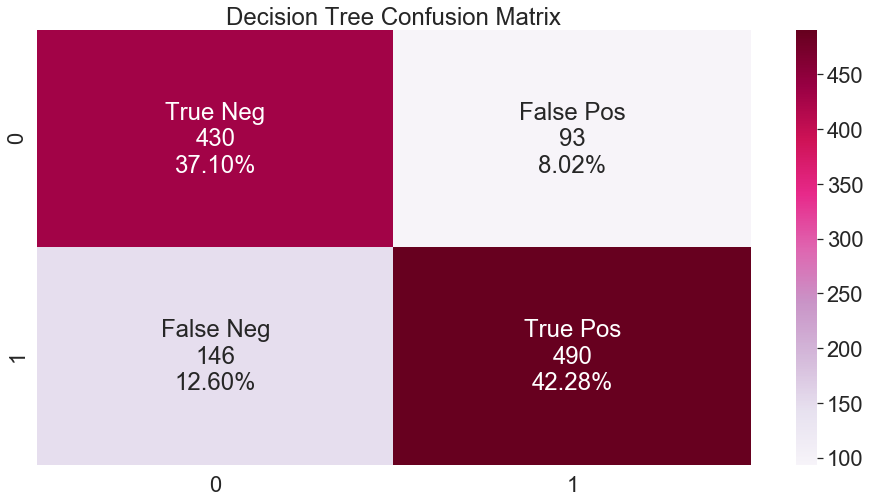

In [36]:
plotconfusionmatrix (y_test, y_pred, modelname = "Decision Tree")

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       523
         1.0       0.84      0.77      0.80       636

    accuracy                           0.79      1159
   macro avg       0.79      0.80      0.79      1159
weighted avg       0.80      0.79      0.79      1159



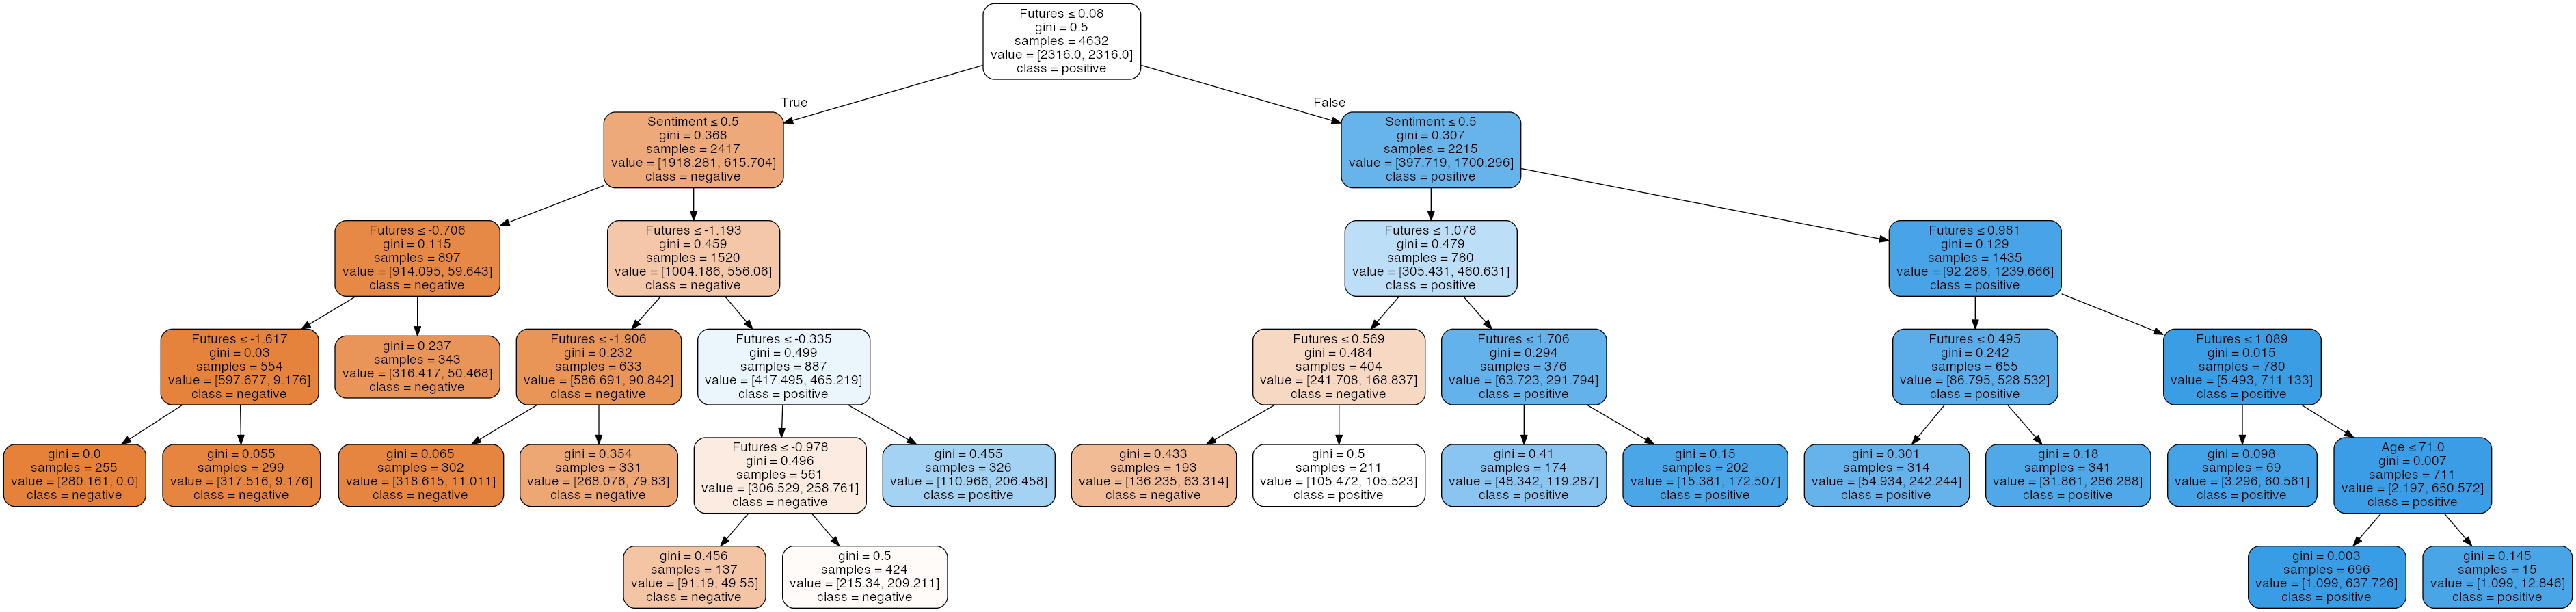

In [38]:
import graphviz
import pydotplus
from IPython.display import Image  
from sklearn import tree
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"


dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X_test.columns,
                               class_names=["negative", "positive"],
                               filled=True, rounded=True,
                               special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [39]:
# Create PDF
graph.write_pdf("dtree.pdf")

# Create PNG
graph.write_png("dtree.png")

True

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00014
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.82481
Feature: 4, Score: 0.17505


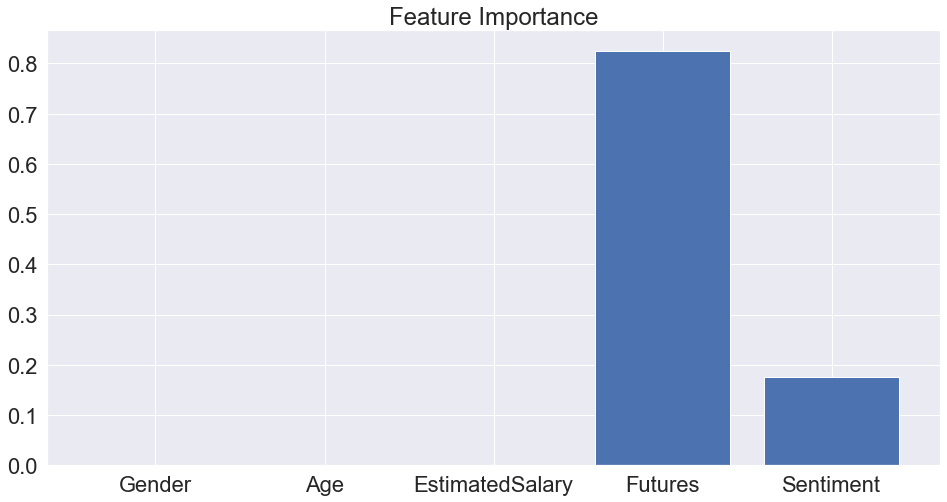

In [40]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(0,5), X_train.columns)
plt.title("Feature Importance")
plt.show()